In [88]:
import os
import cmdstanpy
from cmdstanpy import Model, StanFit, cmdstan_path
from cmdstanpy import Model, StanFit
import ujson as json

<h3> 1. Example: Running the model on Men's World Cup 2014 data</h3>

In [89]:
with open('2014_mwc_data/worldcup_2014.data.json', 'r') as fd:
    data_dict = json.load(fd)
data_dict.keys()

# stan_wc = Model(stan_file='worldcup_rep_ag.stan')
# stan_wc.compile()
# stan_wc

# worldcup_fit = stan_wc.sample(data=data_dict, chains=4)
# worldcup_fit.diagnose()
# worldcup_fit.summary()

dict_keys(['I', 'N', 'team_1', 'team_2', 'score_1', 'score_2', 'prior_score'])

In [90]:
with open('2014_mwc_data/countries.data.json', 'r') as fd_country:
    country_dict = json.load(fd_country)
country_dict

{'countries': [[1, 'Bresil'],
  [2, 'Argentine'],
  [3, 'Allemagne'],
  [4, 'Espagne'],
  [5, 'Chili'],
  [6, 'France'],
  [7, 'Colombie'],
  [8, 'Uruguay'],
  [9, 'Angleterre'],
  [10, 'Belgique'],
  [11, 'Pays-Bas'],
  [12, 'Bosnie'],
  [13, 'Equateur'],
  [14, 'Portugal'],
  [15, "Coted'Ivoire"],
  [16, 'Russie'],
  [17, 'Italie'],
  [18, 'Suisse'],
  [19, 'Etats-Unis'],
  [20, 'Mexique'],
  [21, 'Ghana'],
  [22, 'Grece'],
  [23, 'Croatie'],
  [24, 'Nigeria'],
  [25, 'Coree'],
  [26, 'CostaRica'],
  [27, 'Japon'],
  [28, 'Cameroun'],
  [29, 'Iran'],
  [30, 'Honduras'],
  [31, 'Algerie'],
  [32, 'Australie']]}

<h3> 2. Women' World Cup Data 2019 </h3>

In [91]:
import pandas as pd
matches = pd.read_csv("538_data/wwc_matches.csv")
forecasts = pd.read_csv("538_data/wwc_forecasts.csv")
print(matches.columns, forecasts.columns)

Index(['date', 'league_id', 'league', 'team1', 'team2', 'spi1', 'spi2',
       'prob1', 'prob2', 'probtie', 'proj_score1', 'proj_score2', 'score1',
       'score2', 'xg1', 'xg2', 'nsxg1', 'nsxg2', 'adj_score1', 'adj_score2'],
      dtype='object') Index(['forecast_timestamp', 'team', 'group', 'spi', 'global_o', 'global_d',
       'sim_wins', 'sim_ties', 'sim_losses', 'sim_goal_diff', 'goals_scored',
       'goals_against', 'group_1', 'group_2', 'group_3', 'group_4',
       'make_round_of_16', 'make_quarters', 'make_semis', 'make_final',
       'win_league', 'timestamp'],
      dtype='object')


In [92]:
#quarter-final info not yet filled in! Wikipedia to the rescue:[0,1,0,1]
matches.score1.iloc[[44, 45, 46, 47]] = [0,1,0,1]
matches.score2.iloc[[44, 45, 46, 47]] = [3,2,2,2]

/Users/nitya/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [93]:
matches['team1'] = matches['team1'].apply(lambda x: x.split('Women')[0].rstrip())
matches['team2'] = matches['team2'].apply(lambda x: x.split('Women')[0].rstrip())

In [94]:
#Make a match-list dictionary!
match_list = [matches['team1'][i] + ' vs ' + matches['team2'][i] for i in range(len(matches))]
match_list_dict = dict(zip(list(range(1, len(match_list)+1)), match_list))

In [95]:
len(matches.team2.unique()), len(matches.team1.unique()), len(forecasts.team.unique())

(24, 24, 24)

In [96]:
#spi is the soccer power index: i.e., the "abilities" of the teams
#Getting the scores before the tournament

prior_tournament = forecasts[forecasts['forecast_timestamp']=='2019-05-16 18:22:11 UTC']
countries = prior_tournament[['team', 'spi']].sort_values(by=['spi'], ascending=False)
wwc2019_country = countries['team'].values

['USA' 'France' 'Germany' 'Australia' 'Netherlands' 'England' 'Japan'
 'Canada' 'Brazil' 'Sweden' 'Spain' 'New Zealand' 'Norway' 'China'
 'South Korea' 'Italy' 'Nigeria' 'Cameroon' 'South Africa' 'Jamaica'
 'Scotland' 'Thailand' 'Chile' 'Argentina']


In [97]:
#Creating a dictionary and the 'reverse' dictionary which might be useful later
spi_dict = dict(zip(wwc2019_country, list(range(1, len(wwc2019_country)+1))))
spi_dict_r = dict(zip(list(range(1, len(wwc2019_country)+1)), wwc2019_country))

In [98]:
import numpy as np
mean = np.mean(countries['spi'])
std = np.std(countries['spi'])

#Rescaling the prior!
countries['prior_score'] = [(x - mean)/std for x in countries['spi']]

<h3> 3. Data input for CmdStanPy/Stan </h3>

Data input needs to be in a dictionary format;
Keys in the dictionary are the names of the variables in the data block of the stan model;

In [99]:
N = len(matches)
I = len(wwc2019_country)
mydict = dict({'I': I,
               'N': N,
                'team_1': matches['team1'].values,
               'team_2': matches['team2'].values,
               'score_1': matches['score1'].values,
               'score_2': matches['score2'].values,
              'prior_score': countries['prior_score'].values})

In [100]:
#Replace team names by their rankings;

mydict['team_1'] = [spi_dict.get(x) for x in mydict['team_1']]
mydict['team_2'] = [spi_dict.get(x) for x in mydict['team_2']]

In [101]:
stan_wc = Model(stan_file='worldcup_rep_ag.stan')
stan_wc.compile()
stan_wc

INFO:cmdstanpy:compiling c++
INFO:cmdstanpy:compiled model file: /Users/nitya/Work/test_tutorial/worldcup_rep_ag


Model(name=worldcup_rep_ag,  stan_file="worldcup_rep_ag.stan", exe_file="/Users/nitya/Work/test_tutorial/worldcup_rep_ag")

In [102]:
worldcup_fit = stan_wc.sample(data=mydict, chains=4)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 4


In [103]:
worldcup_fit.diagnose()


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


'Processing csv files: /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpmpkn__98/stan-worldcup_rep_ag-draws-1-ypbsiry5.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpmpkn__98/stan-worldcup_rep_ag-draws-2-usdy4qqi.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpmpkn__98/stan-worldcup_rep_ag-draws-3-b6jd3nof.csv, /var/folders/p4/76cck04j075g95k8wbfvw1ch0000gn/T/tmpmpkn__98/stan-worldcup_rep_ag-draws-4-4a7ubu68.csv\n\nChecking sampler transitions treedepth.\nTreedepth satisfactory for all transitions.\n\nChecking sampler transitions for divergences.\nNo divergent transitions found.\n\nChecking E-BFMI - sampler transitions HMC potential energy.\nE-BFMI satisfactory for all transitions.\n\nEffective sample size satisfactory.\n\nSplit R-hat values satisfactory all parameters.\n\nProcessing complete, no problems detected.'

In [104]:
df = worldcup_fit.summary().round(decimals = 2)
df

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
lp__,-52.46,0.32,6.88,-64.87,-51.94,-42.38,462.15,370.42,1.0
beta,0.94,0.01,0.26,0.49,0.94,1.37,1619.32,1297.92,1.0
alpha[1],0.98,0.01,0.69,-0.13,0.98,2.09,2594.66,2079.66,1.0
alpha[2],0.32,0.01,0.65,-0.70,0.32,1.41,3351.86,2686.57,1.0
alpha[3],0.42,0.01,0.65,-0.65,0.42,1.48,3346.86,2682.56,1.0
alpha[4],-0.19,0.01,0.68,-1.31,-0.19,0.94,3843.73,3080.82,1.0
alpha[5],0.46,0.01,0.64,-0.55,0.45,1.53,3980.35,3190.32,1.0
alpha[6],0.55,0.01,0.70,-0.63,0.57,1.63,3224.42,2584.43,1.0
alpha[7],-0.74,0.01,0.74,-1.96,-0.73,0.42,2866.64,2297.66,1.0



What you see above above is a dataframe of the summary of the "stanfit" object:

From the Stan webpage: (https://mc-stan.org/rstan/reference/stanfit-class.html)<br>
An object of class stanfit contains the output derived from fitting a Stan model as returned by the top-level function stan or the lower-level methods sampling and vb (which are defined on class stanmodel). Many methods (e.g., print, plot, summary) are provided for summarizing results and various access methods also allow the underlying data (e.g., simulations, diagnostics) contained in the object to be retrieved.

The summary method returns a named list with elements summary and c_summary, which contain summaries for for all chains merged and individual chains, respectively. Included in the summaries are quantiles, means, standard deviations (sd), effective sample sizes (n_eff), and split Rhats (the potential scale reduction derived from all chains after splitting each chain in half and treating the halves as chains). For the summary of all chains merged, Monte Carlo standard errors (se_mean) are also reported.


<h3> 4. Interpreting the Fit Summary </h3>

In [105]:
dft = df.transpose()
ability_filter = [col for col in dft if col.startswith('ability')]
yrep_filter = [col for col in dft if col.startswith('y_rep')]

In [106]:
#Abilities
abilities = dft[ability_filter]

#Team Differentials
td = dft[yrep_filter]

In [107]:
abilities

name,ability[1],ability[2],ability[3],ability[4],ability[5],ability[6],ability[7],ability[8],ability[9],ability[10],...,ability[15],ability[16],ability[17],ability[18],ability[19],ability[20],ability[21],ability[22],ability[23],ability[24]
Mean,2.02,1.28,1.32,0.68,1.27,1.39,0.18,0.65,0.60,1.02,...,-1.04,0.56,-0.60,-0.62,-1.38,-2.09,-0.84,-2.56,-1.11,-0.93
MCSE,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,...,0.03,0.01,0.01,0.01,0.01,0.02,0.02,0.02,0.01,0.03
StdDev,0.64,0.56,0.56,0.61,0.56,0.60,0.61,0.57,0.59,0.55,...,0.79,0.63,0.63,0.59,0.65,0.75,0.75,0.79,0.67,0.89
5%,1.02,0.37,0.43,-0.33,0.35,0.43,-0.82,-0.30,-0.38,0.15,...,-2.36,-0.41,-1.67,-1.56,-2.46,-3.37,-1.99,-3.92,-2.18,-2.41
50%,2.02,1.27,1.30,0.70,1.27,1.37,0.18,0.66,0.60,1.01,...,-1.02,0.54,-0.58,-0.64,-1.35,-2.08,-0.88,-2.55,-1.13,-0.92
95%,3.08,2.22,2.25,1.65,2.18,2.40,1.14,1.59,1.55,1.93,...,0.20,1.63,0.39,0.38,-0.39,-0.92,0.44,-1.31,0.02,0.54
N_Eff,2096.78,4644.57,3534.01,3330.21,4092.74,2424.30,3711.38,4686.44,3875.27,3034.32,...,993.07,2171.11,3640.63,4401.79,3151.41,1246.00,1801.25,2218.79,3212.22,1013.87
N_Eff/s,1680.60,3722.70,2832.57,2669.22,3280.40,1943.12,2974.73,3756.26,3106.10,2432.06,...,795.96,1740.18,2918.03,3528.11,2525.91,998.69,1443.73,1778.40,2574.65,812.63
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [108]:
td

name,y_rep[1],y_rep[2],y_rep[3],y_rep[4],y_rep[5],y_rep[6],y_rep[7],y_rep[8],y_rep[9],y_rep[10],...,y_rep[39],y_rep[40],y_rep[41],y_rep[42],y_rep[43],y_rep[44],y_rep[45],y_rep[46],y_rep[47],y_rep[48]
Mean,2.32,1.42,1.85,0.89,0.11,2.68,2.23,-1.12,1.30,-1.59,...,2.03,0.68,-1.53,0.38,0.59,1.08,-1.12,-0.73,-0.71,0.31
MCSE,0.04,0.03,0.02,0.02,0.03,0.03,0.03,0.04,0.03,0.03,...,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.03,0.03
StdDev,1.75,1.65,1.64,1.63,1.70,1.65,1.67,1.76,1.62,1.65,...,1.69,1.63,1.65,1.61,1.65,1.63,1.71,1.65,1.63,1.60
5%,-0.53,-1.17,-0.85,-1.75,-2.55,-0.05,-0.41,-4.11,-1.36,-4.19,...,-0.68,-1.85,-4.09,-2.27,-2.22,-1.61,-3.80,-3.26,-3.32,-2.22
50%,2.37,1.41,1.89,0.88,0.04,2.73,2.21,-1.03,1.28,-1.60,...,2.02,0.70,-1.55,0.40,0.62,1.06,-1.14,-0.75,-0.68,0.26
95%,4.93,4.03,4.35,3.48,2.84,5.33,4.92,1.57,3.95,1.11,...,4.63,3.19,1.19,2.91,3.14,3.73,1.67,1.91,1.85,2.93
N_Eff,2447.87,3804.17,4396.90,4436.54,3804.29,2817.30,4117.77,2006.46,3864.06,4088.51,...,3894.03,4137.71,3734.34,3870.74,3225.01,4363.29,3233.49,3899.47,3967.66,3924.28
N_Eff/s,1962.01,3049.11,3524.19,3555.96,3049.21,2258.11,3300.46,1608.21,3097.11,3277.01,...,3121.13,3316.44,2993.14,3102.47,2584.90,3497.25,2591.70,3125.49,3180.14,3145.38
R_hat,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,...,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


<h3> Plots! </h3>

In [109]:
df_teamdifferentials = pd.DataFrame({'midway': td.loc['50%'].values,
                                       'names': match_list})
df_teamdifferentials.loc[:, 'left'] = td.loc['5%'].values
df_teamdifferentials.loc[:, 'right'] = td.loc['95%'].values

In [110]:
actual_differentials = np.array([matches['score1'][i]-matches['score2'][i]  for i in range(len(matches))])

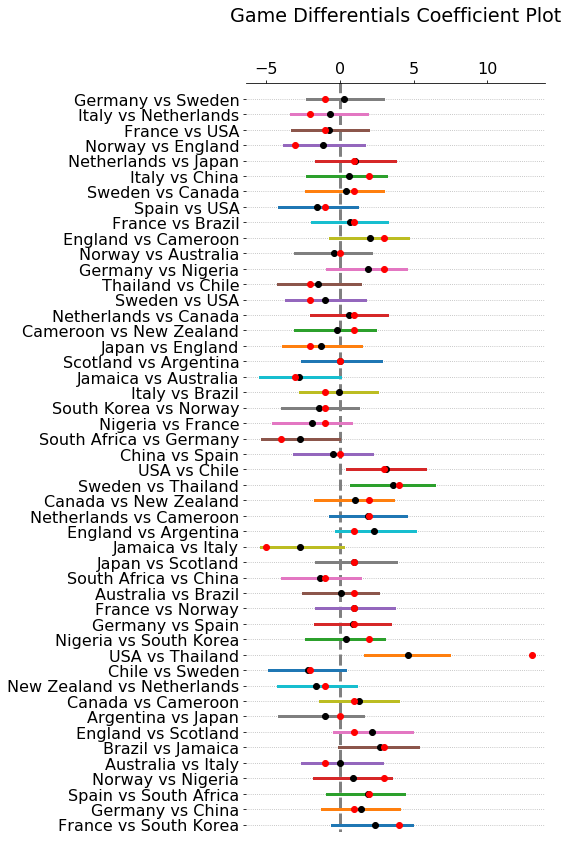

In [117]:
from coefplot import coefficient_plot

coefficient_plot(df_teamdifferentials['midway'], df_teamdifferentials['left'], 
                 df_teamdifferentials['right'], actual_differentials, 
                 names=df_teamdifferentials['names'],
                 title='Game Differentials Coefficient Plot')
plt.tight_layout()
plt.savefig('/Users/nitya/Desktop/Predictions.png')

In [115]:
df_abilities = pd.DataFrame({'midway': abilities.loc['50%'].values,
                                       'names': wwc2019_country})
df_abilities.loc[:, 'left'] = abilities.loc['5%'].values
df_abilities.loc[:, 'right'] = abilities.loc['95%'].values

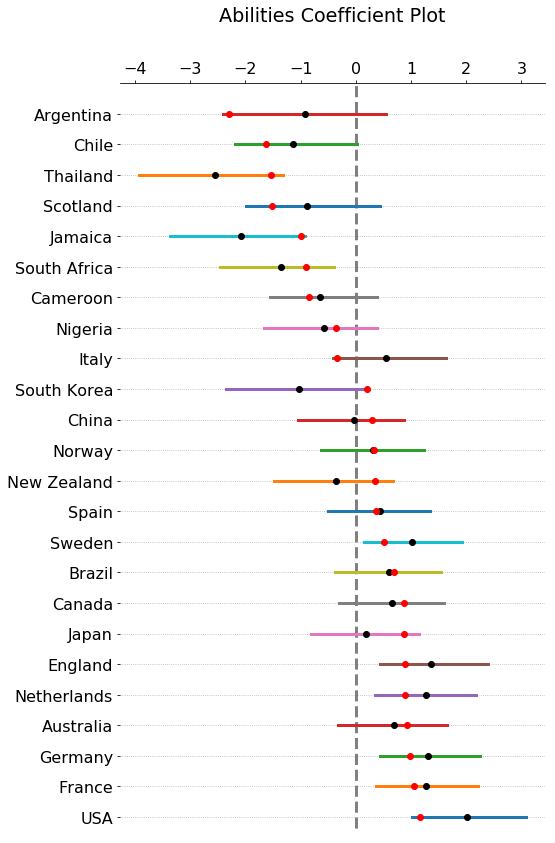

In [116]:
coefficient_plot(df_abilities['midway'], df_abilities['left'], 
                 df_abilities['right'], countries['prior_score'], 
                 names=df_abilities['names'],
                 title='Abilities Coefficient Plot')
plt.tight_layout()
plt.savefig('/Users/nitya/Desktop/Predictions_abilities.png')

#Standalone generated quantities - do about a thousand draws for semis